In [7]:
import time
import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bt
import h5py

from datetime import datetime
import yfinance as yf

c:\Python312\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.0 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [8]:
tickers_new = 'aapl,msft,c,gs,ge,jnj,pg,ko,amzn,jpm,adbe,ma,dis,txn'
data = bt.get(
    tickers_new,
    start='2010-01-01',
    end = '2022-07-01'
)
data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,aapl,msft,c,gs,ge,jnj,pg,ko,amzn,jpm,adbe,ma,dis,txn
Date,,,,,,,,,,,,,,
2010-01-04,6.478998,23.474920,26.893297,136.536926,67.992638,42.974453,40.160057,18.498020,6.695000,29.669851,37.090000,23.853483,27.843178,18.196342
2010-01-05,6.490199,23.482508,27.921574,138.950821,68.344696,42.476151,40.173199,18.274248,6.734500,30.244547,37.700001,23.782904,27.773722,18.091412
2010-01-06,6.386963,23.338388,28.791643,137.467758,67.992638,42.821632,39.982658,18.267761,6.612500,30.410727,37.619999,23.748516,27.626127,17.958487
2010-01-07,6.375157,23.095688,28.870747,140.157852,71.513298,42.516022,39.765820,18.222357,6.500000,31.013124,36.889999,23.593325,27.634806,18.014452
2010-01-08,6.417542,23.254963,28.396154,137.507309,73.053589,42.662174,39.713257,17.885096,6.676000,30.936958,36.689999,23.601692,27.678219,18.427214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-24,140.444199,264.041077,44.782078,289.353027,52.030643,174.613434,138.010956,60.242382,116.459999,111.237900,387.720001,326.949310,97.462357,149.027634
2022-06-27,140.444199,261.269440,44.754002,287.470154,51.805435,174.450592,136.959244,60.118156,113.220001,110.346634,381.070007,325.297302,96.296165,148.712280
2022-06-28,136.260406,252.974411,44.173874,286.237213,51.160873,169.488739,134.731583,59.516106,107.400002,109.815674,365.630005,314.870514,95.608398,147.317093


In [9]:
sma = data.rolling(50).mean()

st = time.time()
class SelectWhere(bt.Algo):

    """
    Selects securities based on an indicator DataFrame.

    Selects securities where the value is True on the current date (target.now).

    Args:
        * signal (DataFrame): DataFrame containing the signal (boolean DataFrame)

    Sets:
        * selected

    """
    def __init__(self, signal):
        self.signal = signal

    def __call__(self, target):
        # get signal on target.now
        if target.now in self.signal.index:
            sig = self.signal.loc[target.now]

            # get indices where true as list
            selected = list(sig.index[sig])

            # save in temp - this will be used by the weighing algo
            target.temp['selected'] = selected

        # return True because we want to keep on moving down the stack
        return True
    
signal = data > sma


# first we create the Strategy
s = bt.Strategy('above50sma', [SelectWhere(data > sma),
                               bt.algos.WeighEqually(),
                               bt.algos.Rebalance()])

# now we create the Backtest
t = bt.Backtest(s, data)

# and let's run it!
res = bt.run(t)
et = time.time()

print(f"Run time: {et-st:.2f} seconds") 
bt_runtime_seconds = et-st
res.display()

Run time: 1.43 seconds
Stat                 above50sma
-------------------  ------------
Start                2010-01-03
End                  2022-06-30
Risk-free rate       0.00%

Total Return         262.07%
Daily Sharpe         0.70
Daily Sortino        1.06
CAGR                 10.85%
Max Drawdown         -31.75%
Calmar Ratio         0.34

MTD                  -13.76%
3m                   -24.47%
6m                   -26.27%
YTD                  -26.12%
1Y                   -29.33%
3Y (ann.)            2.06%
5Y (ann.)            4.92%
10Y (ann.)           12.00%
Since Incep. (ann.)  10.85%

Daily Sharpe         0.70
Daily Sortino        1.06
Daily Mean (ann.)    11.73%
Daily Vol (ann.)     16.78%
Daily Skew           -0.71
Daily Kurt           5.40
Best Day             5.27%
Worst Day            -8.03%

Monthly Sharpe       0.69
Monthly Sortino      1.09
Monthly Mean (ann.)  11.91%
Monthly Vol (ann.)   17.16%
Monthly Skew         -0.89
Monthly Kurt         1.75
Best Month          

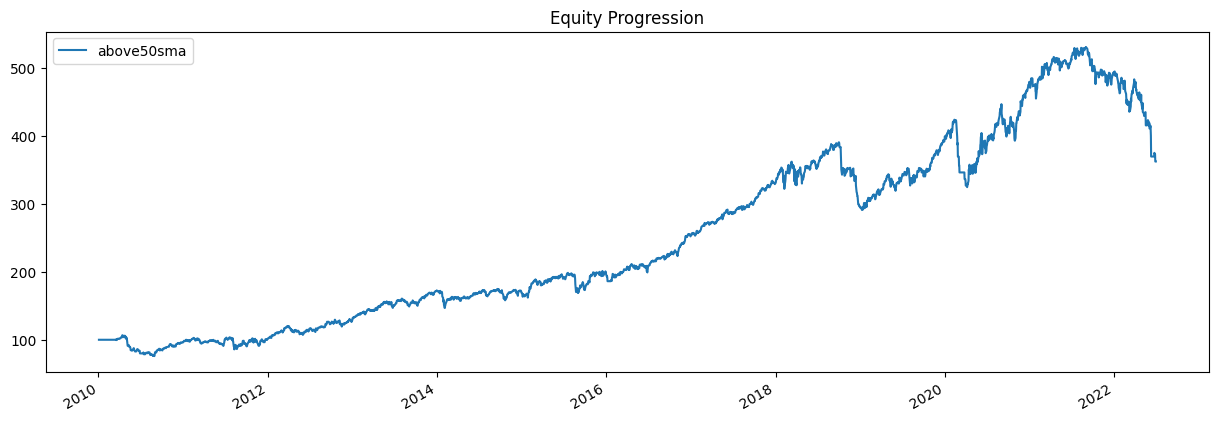

In [10]:
# what does the equity curve look like?
res.plot();

In [11]:
import sys

atlas_path = "C:/Users/natha/OneDrive/Desktop/C++/Atlas/x64/Release"
sys.path.append(atlas_path)

from AtlasPy.core import Hydra, Portfolio, Strategy
from AtlasPy import TracerType
from AtlasPy.ast import AssetReadNode, AssetDifferenceNode, AssetQuotientNode, \
      ExchangeViewNode, AllocationNode, StrategyNode, AssetOpNodeVariant, \
            ExchangeViewFilterType, AllocationType

In [20]:
exchange_id = "test"
portfolio_id = "test_p"
strategy_id = "test_s"
exchange_path_fast = "C:/Users/natha/OneDrive/Desktop/C++/Atlas/AtlasPy/test/data_sp500.h5"
initial_cash = 100.0

hydra = Hydra()

In [21]:
exchange = hydra.addExchange(exchange_id, exchange_path_fast)
portfolio = hydra.addPortfolio(portfolio_id, exchange, initial_cash)
hydra.build()

In [22]:
read_close = AssetReadNode.make("close", 0, exchange)
read_50_ma = AssetReadNode.make("50_ma", 0, exchange)
spread = AssetDifferenceNode(read_close, read_50_ma)
op_variant = AssetOpNodeVariant(spread)

exchange_view = ExchangeViewNode(exchange, op_variant)
exchange_view.setFilter(ExchangeViewFilterType.GREATER_THAN, 0.0)
allocation = AllocationNode(exchange_view)
strategy_node = StrategyNode(allocation, portfolio)
strategy = hydra.addStrategy(
    Strategy(strategy_id, strategy_node, 1.0),
    replace_if_exists=True
)
strategy.enableTracerHistory(TracerType.NLV)

In [23]:
time_sum = 0
n = 1
for i in range(n):
    st = time.perf_counter_ns()
    hydra.run()
    et = time.perf_counter_ns()
    time_sum += et - st

avg_time_micros = (time_sum / n) / 1000

tr = (strategy.getNLV() - initial_cash) / initial_cash
print(f"Time elapsed Avg: {avg_time_micros:.3f} us")
print(f"Total return: {tr:.3%}")
print(f"Epsilon: {tr - 2.6207}")

Time elapsed Avg: 676.600 us
Total return: 262.109%
Epsilon: 0.0003877146672262022


In [24]:
bt_runtime_micros = bt_runtime_seconds * 1000000
speedup = bt_runtime_micros / avg_time_micros
print(f"Speedup: {speedup:.3f}x")

Speedup: 2117.956x


C:\Users\natha\AppData\Local\Temp\ipykernel_1608\2118328846.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res["Atlas"] = strategy.getHistory(TracerType.NLV)


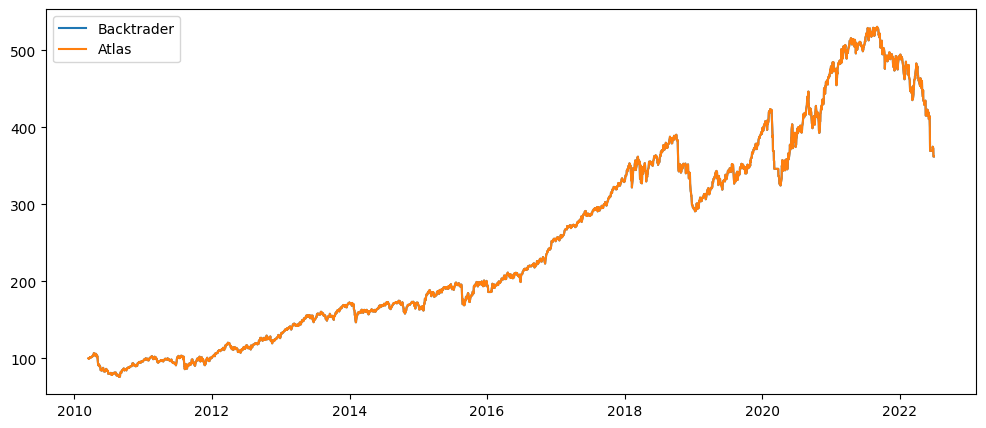

In [25]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)

df_res = res.prices.iloc[50:]
df_res["Atlas"] = strategy.getHistory(TracerType.NLV)

ax.plot(df_res["above50sma"], label='Backtrader')
ax.plot(df_res["Atlas"], label='Atlas')

ax.legend()

In [26]:
tickers_new = 'aapl,msft,c,gs,ge,jnj,pg,ko,amzn,jpm,adbe,ma,dis,txn'
data = bt.get(tickers_new, start='2010-01-01')
sma50 = data.rolling(50).mean()
sma200 = data.rolling(200).mean()
data.shape

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


(3535, 14)

In [27]:
class WeighTarget(bt.Algo):
    def __init__(self, target_weights):
        self.tw = target_weights

    def __call__(self, target):
        if target.now in self.tw.index:
            w = self.tw.loc[target.now]
            target.temp['weights'] = w.dropna()

        return True
    
st = time.time()

## now we need to calculate our target weight DataFrame
# first we will copy the sma200 DataFrame since our weights will have the same strucutre
tw = sma200.copy()

# set appropriate target weights
tw[sma50 > sma200] = 1.0
tw[sma50 <= sma200] = -1.0

# divide by row sum to normalize
tw = tw.div(tw.abs().sum(axis=1), axis=0)

# replace nans with 0.0
tw[sma200.isnull()] = 0.0

ma_cross = bt.Strategy('ma_cross', [WeighTarget(tw),
                                    bt.algos.Rebalance()])

t = bt.Backtest(ma_cross, data)
res = bt.run(t)
et = time.time()
print(f"Run time: {et-st:.2f} seconds")
res.display()

Run time: 2.20 seconds
Stat                 ma_cross
-------------------  ----------
Start                2010-01-03
End                  2024-01-19
Risk-free rate       0.00%

Total Return         110.16%
Daily Sharpe         0.47
Daily Sortino        0.70
CAGR                 5.43%
Max Drawdown         -31.51%
Calmar Ratio         0.17

MTD                  0.50%
3m                   0.57%
6m                   -1.65%
YTD                  0.50%
1Y                   4.57%
3Y (ann.)            5.59%
5Y (ann.)            1.47%
10Y (ann.)           5.04%
Since Incep. (ann.)  5.43%

Daily Sharpe         0.47
Daily Sortino        0.70
Daily Mean (ann.)    6.18%
Daily Vol (ann.)     13.28%
Daily Skew           -0.79
Daily Kurt           22.81
Best Day             10.29%
Worst Day            -10.27%

Monthly Sharpe       0.50
Monthly Sortino      0.78
Monthly Mean (ann.)  6.05%
Monthly Vol (ann.)   12.05%
Monthly Skew         -0.76
Monthly Kurt         1.75
Best Month           9.55%
Worst Mo

<Axes: title={'center': 'Equity Progression'}>

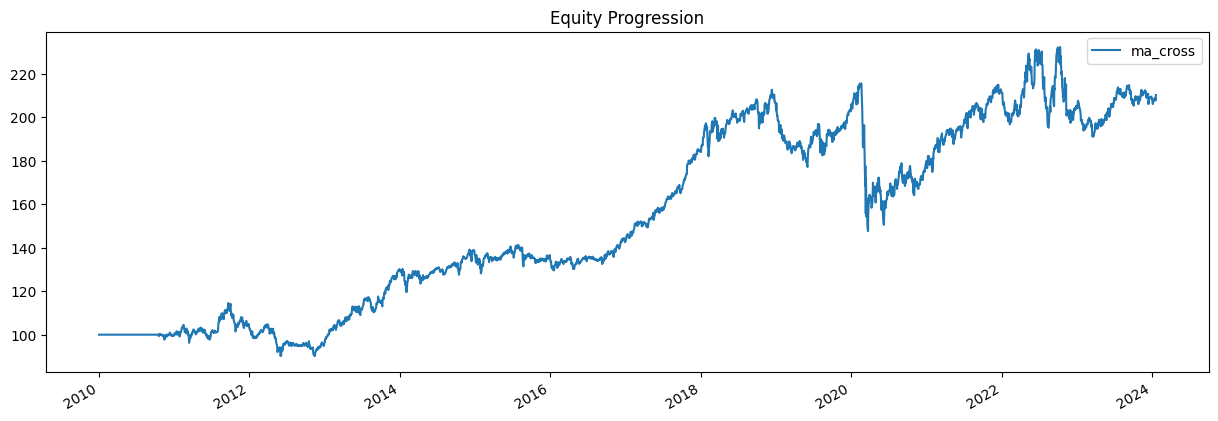

In [28]:
res.plot()

In [29]:
output_path = os.path.join(os.getcwd(), 'data_sp500_ma.h5')
if os.path.exists(output_path):
    os.remove(output_path)
    
for ticker in data.columns:
    df = data[ticker].to_frame()
    df["slow_ma"] = sma200[ticker]
    df["fast_ma"] = sma50[ticker]

    with h5py.File(output_path, "a") as file:
        stock_data = df.to_numpy()
        df.columns = ["close", "slow_ma", "fast_ma"]
        index = df.index.values.astype('int64')
        dataset = file.create_dataset(f"{ticker}/data", data=stock_data)
        file.create_dataset(
                f"{ticker}/datetime",
                data = index,
        )
        for column in df.columns:
            dataset.attrs[column] = column

In [30]:
hydra = Hydra()
exchange = hydra.addExchange(exchange_id, output_path)
portfolio = hydra.addPortfolio(portfolio_id, exchange, initial_cash)
hydra.build()

In [31]:
slow_ma = AssetReadNode.make("slow_ma", 0, exchange)
fast_ma = AssetReadNode.make("fast_ma", 0, exchange)
spread = AssetDifferenceNode(fast_ma, slow_ma)
op_variant = AssetOpNodeVariant(spread)

exchange_view = ExchangeViewNode(exchange, op_variant)
allocation = AllocationNode(exchange_view, AllocationType.CONDITIONAL_SPLIT, 0.0, 0.0)
strategy_node = StrategyNode(allocation, portfolio)
strategy = hydra.addStrategy(Strategy(strategy_id, strategy_node, 1.0))
strategy.enableTracerHistory(TracerType.NLV)

In [32]:
time_sum = 0
n = 1
for i in range(n):
    st = time.perf_counter_ns()
    hydra.run()
    et = time.perf_counter_ns()
    time_sum += et - st

avg_time_micros = (time_sum / n) / 1000

tr = (strategy.getNLV() - initial_cash) / initial_cash
print(f"Time elapsed Avg: {avg_time_micros:.3f} us")
print(f"Total return: {tr:.3%}")
print(f"Epsilon: {tr - 1.1016}")

Time elapsed Avg: 383.500 us
Total return: 110.305%
Epsilon: 0.0014539004526898935


C:\Users\natha\AppData\Local\Temp\ipykernel_1608\3759711916.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results["Atlas"] = strategy.getHistory(TracerType.NLV)


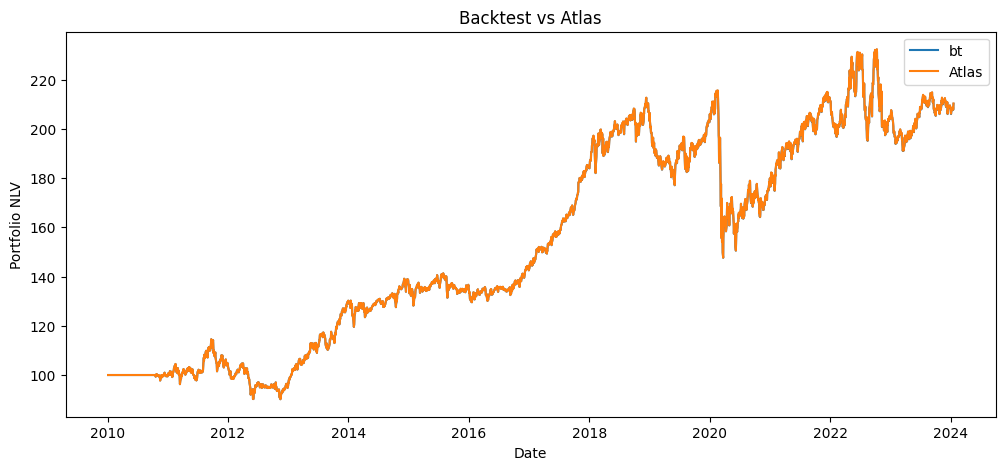

In [34]:
df_results = res.prices
df_results = df_results.iloc[1:]
df_results["Atlas"] = strategy.getHistory(TracerType.NLV)

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
ax.plot(df_results["ma_cross"], label='bt')
ax.plot(df_results["Atlas"], label='Atlas')

ax.set_xlabel('Date')
ax.set_ylabel('Portfolio NLV')
plt.title('Backtest vs Atlas')

_ = ax.legend()

In [44]:
# test buy and hold strategy that fires on the first trading day of the month

runMonthlyAlgo = bt.algos.RunMonthly(
    run_on_first_date=True
)

msft_idx = tickers_new.split(',').index('msft')
amzn_idx = tickers_new.split(',').index('amzn')
jnj_idx = tickers_new.split(',').index('jnj')
weights = np.zeros((len(data.columns)))
weights[msft_idx] = 0.5
weights[amzn_idx] = 0.3
weights[jnj_idx] = 0.2

# algo to set the weights
#  it will only run when runMonthlyAlgo returns true
#  which only happens on the first of every month
weights = pd.Series(weights,index = tickers_new.split(","))
weighSpecifiedAlgo = bt.algos.WeighSpecified(**weights)

# algo to rebalance the current weights to weights set by weighSpecified
#  will only run when weighSpecifiedAlgo returns true
#  which happens every time it runs
rebalAlgo = bt.algos.Rebalance()

# a strategy that rebalances monthly to specified weights
strat = bt.Strategy('static',
    [
        runMonthlyAlgo,
        weighSpecifiedAlgo,
        rebalAlgo
    ]
)

# set integer_positions=False when positions are not required to be integers(round numbers)
backtest = bt.Backtest(
    strat,
    data,
    integer_positions=False
)

res = bt.run(backtest)

In [47]:
res.display()

Stat                 static
-------------------  ----------
Start                2010-01-03
End                  2024-01-19
Risk-free rate       0.00%

Total Return         1475.18%
Daily Sharpe         1.01
Daily Sortino        1.69
CAGR                 21.69%
Max Drawdown         -34.21%
Calmar Ratio         0.63

MTD                  4.32%
3m                   17.98%
6m                   11.61%
YTD                  4.32%
1Y                   54.51%
3Y (ann.)            13.04%
5Y (ann.)            22.18%
10Y (ann.)           23.99%
Since Incep. (ann.)  21.69%

Daily Sharpe         1.01
Daily Sortino        1.69
Daily Mean (ann.)    22.03%
Daily Vol (ann.)     21.76%
Daily Skew           0.08
Daily Kurt           5.38
Best Day             10.31%
Worst Day            -10.01%

Monthly Sharpe       1.19
Monthly Sortino      2.56
Monthly Mean (ann.)  22.05%
Monthly Vol (ann.)   18.49%
Monthly Skew         0.07
Monthly Kurt         0.33
Best Month           17.77%
Worst Month          -11.

In [52]:
weights = res.get_security_weights().head(22)

,msft,jnj,amzn
2010-01-03,0.000000,0.000000,0.000000
2010-01-04,0.500000,0.200000,0.300000
2010-01-05,0.500356,0.197758,0.301887
2010-01-06,0.500756,0.200758,0.298487
2010-01-07,0.501424,0.201688,0.296888
2010-01-08,0.498802,0.199944,0.301254
2010-01-11,0.499224,0.202724,0.298052
2010-01-12,0.500427,0.205647,0.293926
2010-01-13,0.500072,0.204898,0.295030
2010-01-14,0.506860,0.203994,0.289146


In [62]:
returns = data.pct_change().head()[["aapl","jnj","amzn"]]
returns * res.

,aapl,jnj,amzn
Date,,,
2010-01-04,NaN,NaN,NaN
2010-01-05,0.001729,-0.011595,0.005900
2010-01-06,-0.015906,0.008134,-0.018116
2010-01-07,-0.001849,-0.007137,-0.017013
2010-01-08,0.006648,0.003437,0.027077
